<a href="https://colab.research.google.com/github/FaisalT0435/Sistem-Deteksi-Hama-menggunakan-Deep-learning-dan-IoT/blob/main/K_Fold_Faster_RCNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os



In [ ]:
!nvidia-smi

Sun Jan 29 15:51:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Membuat boxes deteksi menggunakan library augmentasi Albumentations 

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class PestDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]

            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

Dataset

Membuat class PetsDetection yang berisi fungsi train data dan labeling 

In [ ]:
#Memanggil dataset
dataset_path = "/content/drive/MyDrive/Dataset/"

In [ ]:
# memanggil file annotation untuk membuat box di data train 
coco = COCO(os.path.join(dataset_path, 'train/','_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=6.90s)
creating index...
index created!


{0: {'id': 0, 'name': 'Pest', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Pest'},
 2: {'id': 2, 'name': 'Sehat', 'supercategory': 'Pest'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Pest'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Pest'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Pest', 'Belalang', 'Sehat', 'Ulat', 'Wereng']

In [ ]:
train_dataset = PestDetection(root=dataset_path, transforms=get_transforms(True))
train_dataset[100]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[ 36.5625,  14.0625, 514.6875, 536.2500]]),
  'labels': tensor([3]),
  'image_id': tensor([100]),
  'area': tensor([249670.9062]),
  'iscrowd': tensor([0])})

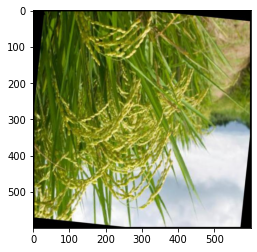

In [ ]:
# contoh data train yang sudah dikasih box
sample = train_dataset[8]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

642

Model Deep Learning Faster RCNN

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
in_features

1024

Membuat dataset  untuk memudahkan masuk ke model 

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(loader):
      
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)
          
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    return(np.mean(all_losses))

In [ ]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4

In [ ]:
from sklearn.model_selection import KFold

dataset = train_dataset
k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)
avg_train_loss = []
avg_val_loss = []
# output = model(images, targets)
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  
  train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

  images,targets = next(iter(train_loader))

  images = list(image for image in images)
  targets = [{k:v for k, v in t.items()} for t in targets]
  
  # output = model(images, targets)

  device = torch.device("cuda")
  
  model = model.to(device)

  optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)

  train_error =[]
  num_epochs=15
  for epoch in range(num_epochs):
    x = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_error.append(x)
#     lr_scheduler.step()
  avg_train_loss.append(sum(train_error) / len(train_error))

FOLD 0
--------------------------------


100%|██████████| 161/161 [00:21<00:00,  7.54it/s]


Epoch 0, lr: 0.000010, loss: 0.182706, loss_classifier: 0.055045, loss_box: 0.117330, loss_rpn_box: 0.009440, loss_object: 0.000890


100%|██████████| 161/161 [00:21<00:00,  7.67it/s]


Epoch 1, lr: 0.000010, loss: 0.179620, loss_classifier: 0.053590, loss_box: 0.115650, loss_rpn_box: 0.009690, loss_object: 0.000691


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 2, lr: 0.000010, loss: 0.180344, loss_classifier: 0.056583, loss_box: 0.113167, loss_rpn_box: 0.009504, loss_object: 0.001091


100%|██████████| 161/161 [00:23<00:00,  6.93it/s]


Epoch 3, lr: 0.000010, loss: 0.191958, loss_classifier: 0.059189, loss_box: 0.122012, loss_rpn_box: 0.009507, loss_object: 0.001250


100%|██████████| 161/161 [00:22<00:00,  7.20it/s]


Epoch 4, lr: 0.000010, loss: 0.184254, loss_classifier: 0.061644, loss_box: 0.112114, loss_rpn_box: 0.009514, loss_object: 0.000982


100%|██████████| 161/161 [00:21<00:00,  7.63it/s]


Epoch 5, lr: 0.000010, loss: 0.180282, loss_classifier: 0.051262, loss_box: 0.119350, loss_rpn_box: 0.009224, loss_object: 0.000446


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


Epoch 6, lr: 0.000010, loss: 0.168665, loss_classifier: 0.048672, loss_box: 0.110239, loss_rpn_box: 0.009215, loss_object: 0.000539


100%|██████████| 161/161 [00:21<00:00,  7.62it/s]


Epoch 7, lr: 0.000010, loss: 0.171023, loss_classifier: 0.050982, loss_box: 0.109652, loss_rpn_box: 0.009238, loss_object: 0.001151


100%|██████████| 161/161 [00:21<00:00,  7.61it/s]


Epoch 8, lr: 0.000010, loss: 0.177316, loss_classifier: 0.057237, loss_box: 0.109777, loss_rpn_box: 0.009173, loss_object: 0.001129


100%|██████████| 161/161 [00:21<00:00,  7.63it/s]


Epoch 9, lr: 0.000010, loss: 0.160077, loss_classifier: 0.050648, loss_box: 0.099881, loss_rpn_box: 0.008965, loss_object: 0.000583


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


Epoch 10, lr: 0.000010, loss: 0.169061, loss_classifier: 0.053068, loss_box: 0.106193, loss_rpn_box: 0.009159, loss_object: 0.000641


100%|██████████| 161/161 [00:21<00:00,  7.61it/s]


Epoch 11, lr: 0.000010, loss: 0.175465, loss_classifier: 0.052360, loss_box: 0.113128, loss_rpn_box: 0.008979, loss_object: 0.000998


100%|██████████| 161/161 [00:21<00:00,  7.61it/s]


Epoch 12, lr: 0.000010, loss: 0.167030, loss_classifier: 0.050695, loss_box: 0.106789, loss_rpn_box: 0.008912, loss_object: 0.000634


100%|██████████| 161/161 [00:21<00:00,  7.62it/s]


Epoch 13, lr: 0.000010, loss: 0.160864, loss_classifier: 0.049885, loss_box: 0.100913, loss_rpn_box: 0.008882, loss_object: 0.001184


100%|██████████| 161/161 [00:21<00:00,  7.62it/s]

Epoch 14, lr: 0.000010, loss: 0.160847, loss_classifier: 0.047636, loss_box: 0.103342, loss_rpn_box: 0.008909, loss_object: 0.000960
FOLD 1
--------------------------------



100%|██████████| 161/161 [00:21<00:00,  7.62it/s]


Epoch 0, lr: 0.000010, loss: 0.165923, loss_classifier: 0.051809, loss_box: 0.104550, loss_rpn_box: 0.008941, loss_object: 0.000623


100%|██████████| 161/161 [00:21<00:00,  7.59it/s]


Epoch 1, lr: 0.000010, loss: 0.163765, loss_classifier: 0.055026, loss_box: 0.098709, loss_rpn_box: 0.008817, loss_object: 0.001214


100%|██████████| 161/161 [00:21<00:00,  7.63it/s]


Epoch 2, lr: 0.000010, loss: 0.154947, loss_classifier: 0.048347, loss_box: 0.097221, loss_rpn_box: 0.008837, loss_object: 0.000543


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


Epoch 3, lr: 0.000010, loss: 0.165186, loss_classifier: 0.050583, loss_box: 0.104866, loss_rpn_box: 0.008968, loss_object: 0.000769


100%|██████████| 161/161 [00:21<00:00,  7.65it/s]


Epoch 4, lr: 0.000010, loss: 0.159283, loss_classifier: 0.046524, loss_box: 0.103123, loss_rpn_box: 0.008858, loss_object: 0.000778


100%|██████████| 161/161 [00:21<00:00,  7.62it/s]


Epoch 5, lr: 0.000010, loss: 0.164591, loss_classifier: 0.052560, loss_box: 0.101849, loss_rpn_box: 0.008729, loss_object: 0.001452


100%|██████████| 161/161 [00:21<00:00,  7.62it/s]


Epoch 6, lr: 0.000010, loss: 0.171585, loss_classifier: 0.058548, loss_box: 0.103307, loss_rpn_box: 0.008894, loss_object: 0.000835


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


Epoch 7, lr: 0.000010, loss: 0.170530, loss_classifier: 0.054256, loss_box: 0.106247, loss_rpn_box: 0.008752, loss_object: 0.001275


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


Epoch 8, lr: 0.000010, loss: 0.158949, loss_classifier: 0.046943, loss_box: 0.102476, loss_rpn_box: 0.008782, loss_object: 0.000748


100%|██████████| 161/161 [00:21<00:00,  7.65it/s]


Epoch 9, lr: 0.000010, loss: 0.149984, loss_classifier: 0.048648, loss_box: 0.091802, loss_rpn_box: 0.008705, loss_object: 0.000828


100%|██████████| 161/161 [00:21<00:00,  7.63it/s]


Epoch 10, lr: 0.000010, loss: 0.156384, loss_classifier: 0.048429, loss_box: 0.098860, loss_rpn_box: 0.008487, loss_object: 0.000608


100%|██████████| 161/161 [00:21<00:00,  7.66it/s]


Epoch 11, lr: 0.000010, loss: 0.157696, loss_classifier: 0.047098, loss_box: 0.101488, loss_rpn_box: 0.008585, loss_object: 0.000526


100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


Epoch 12, lr: 0.000010, loss: 0.157910, loss_classifier: 0.047000, loss_box: 0.101931, loss_rpn_box: 0.008487, loss_object: 0.000492


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 13, lr: 0.000010, loss: 0.143333, loss_classifier: 0.041677, loss_box: 0.092654, loss_rpn_box: 0.008493, loss_object: 0.000510


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]

Epoch 14, lr: 0.000010, loss: 0.140849, loss_classifier: 0.043676, loss_box: 0.088142, loss_rpn_box: 0.008379, loss_object: 0.000652
FOLD 2
--------------------------------



100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


Epoch 0, lr: 0.000010, loss: 0.151253, loss_classifier: 0.045773, loss_box: 0.096520, loss_rpn_box: 0.008469, loss_object: 0.000492


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


Epoch 1, lr: 0.000010, loss: 0.151109, loss_classifier: 0.043395, loss_box: 0.098873, loss_rpn_box: 0.008426, loss_object: 0.000415


100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


Epoch 2, lr: 0.000010, loss: 0.146250, loss_classifier: 0.044200, loss_box: 0.093129, loss_rpn_box: 0.008226, loss_object: 0.000695


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


Epoch 3, lr: 0.000010, loss: 0.153330, loss_classifier: 0.046137, loss_box: 0.097699, loss_rpn_box: 0.008487, loss_object: 0.001007


100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


Epoch 4, lr: 0.000010, loss: 0.144075, loss_classifier: 0.041314, loss_box: 0.094056, loss_rpn_box: 0.008189, loss_object: 0.000516


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


Epoch 5, lr: 0.000010, loss: 0.138578, loss_classifier: 0.042773, loss_box: 0.086967, loss_rpn_box: 0.008366, loss_object: 0.000472


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 6, lr: 0.000010, loss: 0.148091, loss_classifier: 0.044722, loss_box: 0.094591, loss_rpn_box: 0.008176, loss_object: 0.000601


100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


Epoch 7, lr: 0.000010, loss: 0.142327, loss_classifier: 0.045681, loss_box: 0.087883, loss_rpn_box: 0.008098, loss_object: 0.000665


100%|██████████| 161/161 [00:21<00:00,  7.66it/s]


Epoch 8, lr: 0.000010, loss: 0.144860, loss_classifier: 0.043556, loss_box: 0.092419, loss_rpn_box: 0.008173, loss_object: 0.000712


100%|██████████| 161/161 [00:21<00:00,  7.66it/s]


Epoch 9, lr: 0.000010, loss: 0.140321, loss_classifier: 0.042599, loss_box: 0.088844, loss_rpn_box: 0.008088, loss_object: 0.000791


100%|██████████| 161/161 [00:20<00:00,  7.69it/s]


Epoch 10, lr: 0.000010, loss: 0.138859, loss_classifier: 0.043539, loss_box: 0.086755, loss_rpn_box: 0.008075, loss_object: 0.000489


100%|██████████| 161/161 [00:21<00:00,  7.65it/s]


Epoch 11, lr: 0.000010, loss: 0.131990, loss_classifier: 0.040689, loss_box: 0.082939, loss_rpn_box: 0.007895, loss_object: 0.000467


100%|██████████| 161/161 [00:21<00:00,  7.62it/s]


Epoch 12, lr: 0.000010, loss: 0.134791, loss_classifier: 0.048495, loss_box: 0.077045, loss_rpn_box: 0.007965, loss_object: 0.001286


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


Epoch 13, lr: 0.000010, loss: 0.149497, loss_classifier: 0.047534, loss_box: 0.093347, loss_rpn_box: 0.008118, loss_object: 0.000498


100%|██████████| 161/161 [00:21<00:00,  7.65it/s]


Epoch 14, lr: 0.000010, loss: 0.136556, loss_classifier: 0.042816, loss_box: 0.085169, loss_rpn_box: 0.007999, loss_object: 0.000572
FOLD 3
--------------------------------


100%|██████████| 161/161 [00:21<00:00,  7.66it/s]


Epoch 0, lr: 0.000010, loss: 0.144330, loss_classifier: 0.043360, loss_box: 0.092307, loss_rpn_box: 0.008098, loss_object: 0.000565


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 1, lr: 0.000010, loss: 0.133704, loss_classifier: 0.041267, loss_box: 0.084291, loss_rpn_box: 0.007846, loss_object: 0.000300


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


Epoch 2, lr: 0.000010, loss: 0.136901, loss_classifier: 0.039265, loss_box: 0.089354, loss_rpn_box: 0.007890, loss_object: 0.000393


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


Epoch 3, lr: 0.000010, loss: 0.140347, loss_classifier: 0.040465, loss_box: 0.091659, loss_rpn_box: 0.007658, loss_object: 0.000565


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 4, lr: 0.000010, loss: 0.134526, loss_classifier: 0.042631, loss_box: 0.083833, loss_rpn_box: 0.007724, loss_object: 0.000338


100%|██████████| 161/161 [00:20<00:00,  7.69it/s]


Epoch 5, lr: 0.000010, loss: 0.138984, loss_classifier: 0.043299, loss_box: 0.087221, loss_rpn_box: 0.007972, loss_object: 0.000492


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 6, lr: 0.000010, loss: 0.148036, loss_classifier: 0.043573, loss_box: 0.096293, loss_rpn_box: 0.007774, loss_object: 0.000396


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


Epoch 7, lr: 0.000010, loss: 0.136767, loss_classifier: 0.043489, loss_box: 0.084891, loss_rpn_box: 0.007764, loss_object: 0.000623


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


Epoch 8, lr: 0.000010, loss: 0.134740, loss_classifier: 0.037498, loss_box: 0.089021, loss_rpn_box: 0.007837, loss_object: 0.000383


100%|██████████| 161/161 [00:20<00:00,  7.69it/s]


Epoch 9, lr: 0.000010, loss: 0.120228, loss_classifier: 0.034034, loss_box: 0.078190, loss_rpn_box: 0.007617, loss_object: 0.000387


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


Epoch 10, lr: 0.000010, loss: 0.122891, loss_classifier: 0.034892, loss_box: 0.079926, loss_rpn_box: 0.007773, loss_object: 0.000300


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


Epoch 11, lr: 0.000010, loss: 0.121867, loss_classifier: 0.037883, loss_box: 0.076028, loss_rpn_box: 0.007637, loss_object: 0.000319


100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


Epoch 12, lr: 0.000010, loss: 0.128089, loss_classifier: 0.039689, loss_box: 0.080382, loss_rpn_box: 0.007574, loss_object: 0.000443


100%|██████████| 161/161 [00:20<00:00,  7.72it/s]


Epoch 13, lr: 0.000010, loss: 0.126407, loss_classifier: 0.038090, loss_box: 0.080423, loss_rpn_box: 0.007577, loss_object: 0.000317


100%|██████████| 161/161 [00:20<00:00,  7.73it/s]


Epoch 14, lr: 0.000010, loss: 0.132078, loss_classifier: 0.036795, loss_box: 0.087330, loss_rpn_box: 0.007616, loss_object: 0.000337
FOLD 4
--------------------------------


100%|██████████| 161/161 [00:21<00:00,  7.67it/s]


Epoch 0, lr: 0.000010, loss: 0.126074, loss_classifier: 0.037880, loss_box: 0.080376, loss_rpn_box: 0.007309, loss_object: 0.000509


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


Epoch 1, lr: 0.000010, loss: 0.133338, loss_classifier: 0.039733, loss_box: 0.085676, loss_rpn_box: 0.007517, loss_object: 0.000412


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 2, lr: 0.000010, loss: 0.128124, loss_classifier: 0.038200, loss_box: 0.082041, loss_rpn_box: 0.007476, loss_object: 0.000407


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 3, lr: 0.000010, loss: 0.125824, loss_classifier: 0.040344, loss_box: 0.077685, loss_rpn_box: 0.007480, loss_object: 0.000316


100%|██████████| 161/161 [00:20<00:00,  7.69it/s]


Epoch 4, lr: 0.000010, loss: 0.127012, loss_classifier: 0.035865, loss_box: 0.083516, loss_rpn_box: 0.007238, loss_object: 0.000393


100%|██████████| 161/161 [00:21<00:00,  7.64it/s]


Epoch 5, lr: 0.000010, loss: 0.122786, loss_classifier: 0.037857, loss_box: 0.076827, loss_rpn_box: 0.007412, loss_object: 0.000689


100%|██████████| 161/161 [00:20<00:00,  7.73it/s]


Epoch 6, lr: 0.000010, loss: 0.118524, loss_classifier: 0.036109, loss_box: 0.074641, loss_rpn_box: 0.007449, loss_object: 0.000324


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 7, lr: 0.000010, loss: 0.118997, loss_classifier: 0.034855, loss_box: 0.076547, loss_rpn_box: 0.007393, loss_object: 0.000203


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


Epoch 8, lr: 0.000010, loss: 0.119705, loss_classifier: 0.034719, loss_box: 0.077371, loss_rpn_box: 0.007350, loss_object: 0.000265


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 9, lr: 0.000010, loss: 0.125251, loss_classifier: 0.039425, loss_box: 0.078092, loss_rpn_box: 0.007239, loss_object: 0.000495


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 10, lr: 0.000010, loss: 0.119098, loss_classifier: 0.035071, loss_box: 0.076508, loss_rpn_box: 0.007252, loss_object: 0.000268


100%|██████████| 161/161 [00:20<00:00,  7.69it/s]


Epoch 11, lr: 0.000010, loss: 0.124547, loss_classifier: 0.037165, loss_box: 0.079809, loss_rpn_box: 0.007220, loss_object: 0.000353


100%|██████████| 161/161 [00:20<00:00,  7.73it/s]


Epoch 12, lr: 0.000010, loss: 0.122648, loss_classifier: 0.036363, loss_box: 0.078626, loss_rpn_box: 0.007261, loss_object: 0.000397


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 13, lr: 0.000010, loss: 0.118673, loss_classifier: 0.034044, loss_box: 0.077023, loss_rpn_box: 0.007238, loss_object: 0.000368


100%|██████████| 161/161 [00:20<00:00,  7.71it/s]


Epoch 14, lr: 0.000010, loss: 0.129016, loss_classifier: 0.037114, loss_box: 0.084525, loss_rpn_box: 0.007148, loss_object: 0.000229


In [ ]:
avg_train_loss

[0.17396757585260683,
 0.15872766525941603,
 0.14345909189857065,
 0.1333263595274208,
 0.12397458521228895]

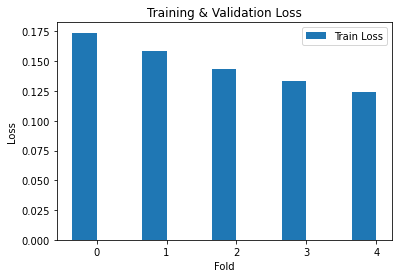

In [ ]:
index = np.arange(5)
x_label = [0,1,2,3,4]
bar_width = 0.35

fig, ax = plt.subplots()
train = ax.bar(index, avg_train_loss, bar_width,
                label="Train Loss")

# valid = ax.bar(index+bar_width, avg_val_loss,
#                  bar_width, label="Validation Loss")

ax.set_xlabel('Fold')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_label)

# ax.set_xticklabels(["ASB", "Violence", "Theft", "Public Order", "Drugs"])
ax.legend()

plt.show()

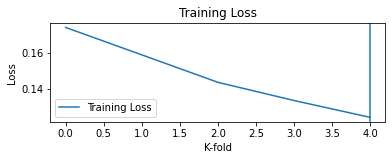

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(avg_train_loss, label='Training Loss')
# ?plt.plot(avg_val_loss, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.axvline(4,  label="Epoch")
# plt.ylabel('merror')
plt.ylabel('Loss')
plt.xlabel('K-fold')
plt.show()

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = PestDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [ ]:
test_dataset

Dataset PestDetection
    Number of datapoints: 170
    Root location: /content/drive/MyDrive/Dataset/
    Compose([
  Resize(always_apply=False, p=1, height=600, width=600, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [ ]:
len(test_dataset)

170

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/Dataset/test/_classes.csv', sep=',')

labels

,filename,Belalang,Sehat,Ulat,Wereng
0,Wereng-33-_jpg.rf.0023f384c26e7d66c8bb905c8fa2...,0,0,0,1
1,Wereng-72-_jpg.rf.0315ec5d8678d3be183582ce1d0d...,0,0,0,1
2,Wereng-25-_jpg.rf.081b03ea5f5b1276fa21e4512f04...,0,0,0,1
3,Ulat-69-_jpg.rf.088d9fd97dc296be8218328df3a723...,0,0,1,0
4,Ulat-62-_jpg.rf.08b9f9275628ae55e0353af40f1230...,1,0,0,0
...,...,...,...,...,...
165,Ulat-91-_jpg.rf.fd8ce17c9ae10811eddf2db9308ede...,0,0,1,0
166,Ulat-78-_jpg.rf.fddb4585975965e29ed434ad977019...,0,0,1,0
167,Wereng-52-_jpg.rf.ffdd05dabb56269f1bd6a8371001...,0,0,0,1
168,Wereng-78-_jpg.rf.fd0f2c13bc628d2e2d3492be8dbc...,0,0,0,1


In [4]:
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

In [5]:
test_labels = labels.apply(get_label, axis=1)

test_labels


0         Wereng
1         Wereng
2         Wereng
3           Ulat
4       Belalang
         ...    
165         Ulat
166         Ulat
167       Wereng
168       Wereng
169         Ulat
Length: 170, dtype: object

In [ ]:
test_dataset = PestDetection(root=dataset_path, split="test", transforms=get_transforms(False))
img, _ = test_dataset[5]
img
dataset_path

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


'/content/drive/MyDrive/Dataset/'

In [ ]:
# import os
# from os import listdir

# hasil_pred = []
# test_dataset = PestDetection(root=dataset_path, split="test", transforms=get_transforms(False))
# # get the path/directory
# folder_dir = "/content/drive/MyDrive/TA/dataset/test/"
# for images in os.listdir(folder_dir):
#     # check if the image ends with png
#     if (images.endswith(".jpg")):
#       img, _ = test_dataset[i]

      


#       images = []   
#       # while(cap.isOpened()):
#           ret, frame = cap.read()
#           if ret == True:
#               result_frame, predict = predict_single_frame(frame)
#               images.append(result_frame)
#               hasil_pred.append (predict)
#           else: 
#               break

#       cap.release()

In [ ]:
print("Score")
tp = []
fp = []
fn = []
predict = []
folder_dir = "/content/drive/MyDrive/Dataset/test/"
for i in range(2):
  img, _ = test_dataset[i]
  img_int = torch.tensor(img*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([img.to(device)])
      pred = prediction[0]

  
  # if(pred['labels'] == 2):
  #   x = "True" 
  # else:
  #   x = "xe"
  # print(x)
  # print(pred['labels'])
  # i = pred['labels'].tolist()
  # print(i)
  # x = classes[i] 
  # predict.append(x)
  

  # x = len(pred['labels'][pred['scores'] > 0.8])
  # y = len(pred['labels'])

  predict.append(pred['labels'].tolist())
  # if (x==1):
  #   tp.append(1)
  # elif (x > 1 ):
  #   fp.append(1)
  # elif (y > 1):
  #   fn.append(1)

  # print( [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], ": ",pred['scores'].tolist() )
  # fig = plt.figure(figsize=(14, 10))
  # plt.imshow(draw_bounding_boxes(img_int,
  #   pred['boxes'][pred['scores'] > 0.8], 
  #   [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
  # ).permute(1, 2, 0))
  

  
# x = pred['labels'][pred['scores'] > 0.8]
# y = pred['labels']
# len(y)   

In [ ]:
predict
predicted = []

for i in range(150):
  if (predict[i] == [1]):
    predicted.append(' Belalang')
  elif (predict[i] == [2]):
    predicted.append(' Sehat')
  elif (predict[i] == [3]):
    predicted.append(' Ulat')
  elif (predict[i] == [4]):
    predicted.append(' Wereng')
  # else:
  #   predicted.append(' Wereng')


predicted

In [18]:
df_hasil_pred = pd.DataFrame(predicted)
df_hasil_pred [1] = pd.DataFrame(test_labels)

df_hasil_pred

,0,1
0,Wereng,Wereng
1,Wereng,Wereng
2,Wereng,Wereng
3,Ulat,Ulat
4,Belalang,Belalang
...,...,...
165,Ulat,Ulat
166,Ulat,Ulat
167,Wereng,Wereng
168,Wereng,Wereng


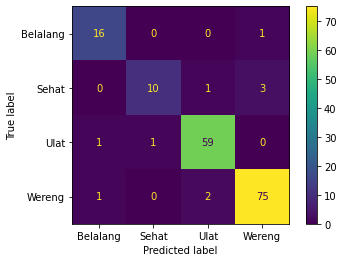

In [19]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = df_hasil_pred[0]
predicted = df_hasil_pred[1]

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Belalang', 'Sehat', 'Ulat', 'Wereng'])

cm_display.plot()
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted, target_names=['Belalang', 'Sehat', 'Ulat', 'Wereng']))

              precision    recall  f1-score   support

    Belalang       0.89      0.94      0.91        17
       Sehat       0.91      0.71      0.80        14
        Ulat       0.95      0.97      0.96        61
      Wereng       0.95      0.96      0.96        78

    accuracy                           0.94       170
   macro avg       0.92      0.90      0.91       170
weighted avg       0.94      0.94      0.94       170



In [ ]:
import random
import time

from paho.mqtt import client as mqtt_client

broker = 'broker.emqx.io'
port = 1883
topic1 = "detect/hama"
# topic0 = "detect/healthy"
# generate client ID with pub prefix randomly
client_id = f'python-mqtt-{random.randint(0, 1000)}'
username = 'emqx'
password = 'public'

def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client


def publish(client):
    
    msg_count = 0
    msg = ''
    while True:
        time.sleep(1)
        # pred = predict()
        # print (pred)
        deteksi = []
        for i in predicted:
            if (i == ' Belalang' or i == ' Wereng' or i == ' Ulat')  :
                j = 'Pest'
                deteksi.append(j)
            else:
                j = 'healthy'
                deteksi.append(j)
        # print (deteksi)
    
        for x in deteksi:
            if (x == 'Pest'):
                msg = "Pest"
                result = client.publish(topic1, msg)
                status = result[0]
                if status == 0:
                    print(f"Send `{msg}` to topic `{topic1}`")
                else:
                    print(f"Failed to send message to topic {topic1}")


def run():
    client = connect_mqtt()
    client.loop_start()
    publish(client)


In [ ]:
run()

In [ ]:
print("Score")
tp = []
fp = []
fn = []

for i in range(30,100):
  img, _ = test_dataset[i]
  img_int = torch.tensor(img*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([img.to(device)])
      pred = prediction[0]


  x = len(pred['labels'][pred['scores'] > 0.8])
  y = len(pred['labels'])
  if (x==1):
    tp.append(1)
  elif (x > 1 ):
    fp.append(1)
  elif (y > 1):
    fn.append(1)

  # print( [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], ": ",pred['scores'].tolist() )
  fig = plt.figure(figsize=(14, 10))
  plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8], 
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
  ).permute(1, 2, 0))
  

  
# x = pred['labels'][pred['scores'] > 0.8]
# y = pred['labels']
# len(y)   
  
